In [1]:
import pandas as pd

train_df = pd.read_csv('train.csv')

In [2]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train_df.shape

(159571, 8)

In [4]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train_df[label_cols].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [6]:
# accuracy might not be a good measure here

## EDA

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [8]:
train_df['label_count'] = train_df[label_cols].sum(axis=1)

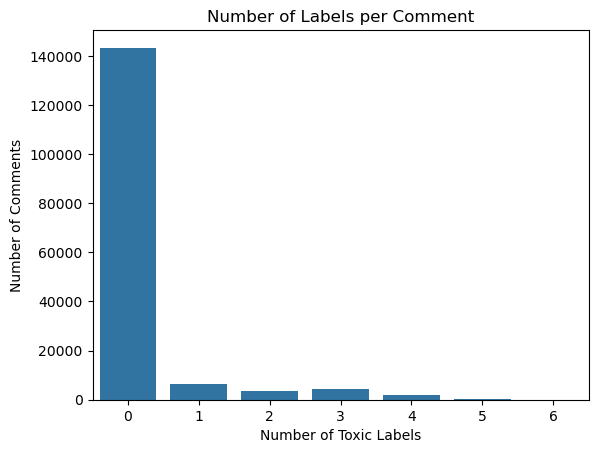

In [9]:
# Visualize number of labels per comment
sns.countplot(x='label_count', data=train_df)
plt.title('Number of Labels per Comment')
plt.xlabel('Number of Toxic Labels')
plt.ylabel('Number of Comments')
plt.show()

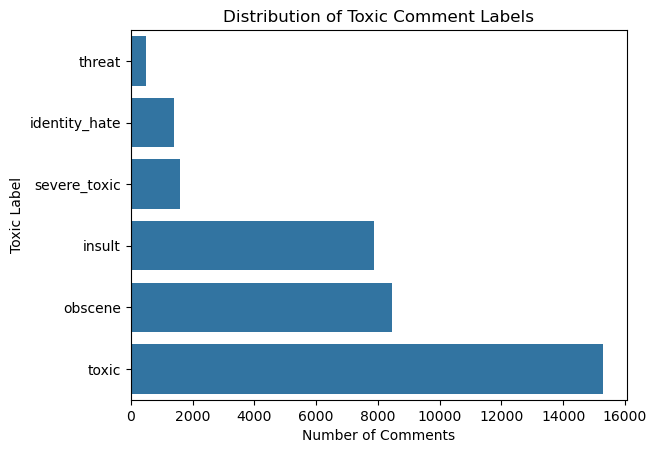

In [10]:
# Plot distribution of each toxic label
label_sums = train_df[label_cols].sum().sort_values()
sns.barplot(x=label_sums.values, y=label_sums.index)
plt.title('Distribution of Toxic Comment Labels')
plt.xlabel('Number of Comments')
plt.ylabel('Toxic Label')
plt.show()

<Axes: xlabel='text_length', ylabel='Count'>

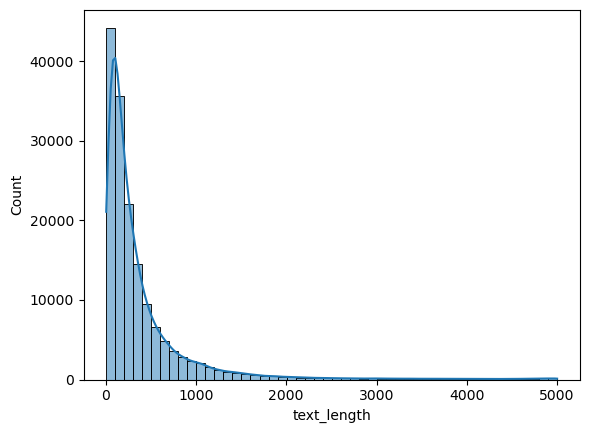

In [11]:
train_df['text_length'] = train_df['comment_text'].str.len()
sns.histplot(train_df['text_length'], bins=50, kde=True)

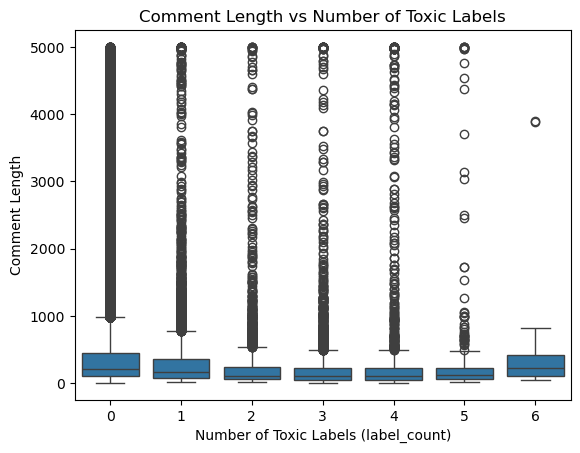

In [12]:
# Plot length vs label count
sns.boxplot(x='label_count', y='text_length', data=train_df)
plt.title("Comment Length vs Number of Toxic Labels")
plt.xlabel("Number of Toxic Labels (label_count)")
plt.ylabel("Comment Length")
plt.show()

In [13]:
# Correlation with each toxic label
corrs = train_df[['text_length'] + label_cols].corr()

corrs['text_length'].drop('text_length')

toxic           -0.054470
severe_toxic     0.010131
obscene         -0.042945
threat          -0.008011
insult          -0.045052
identity_hate   -0.013647
Name: text_length, dtype: float64

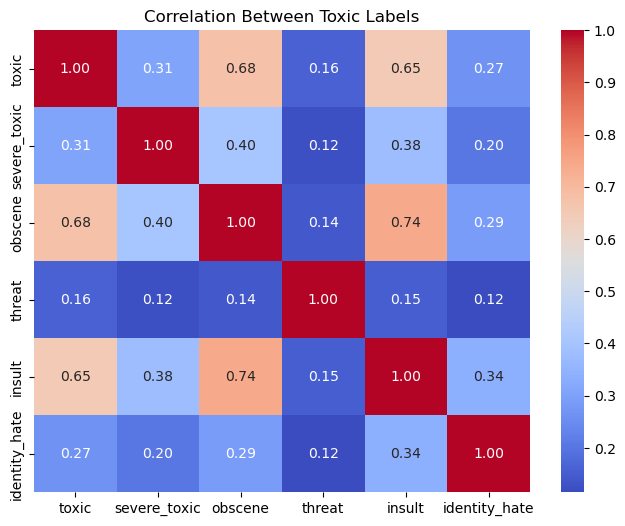

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(train_df[label_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Toxic Labels')
plt.show()

In [15]:
# clean vs toxic
clean_comments = train_df[train_df[label_cols].sum(axis=1) == 0]['comment_text']
toxic_comments = train_df[train_df[label_cols].sum(axis=1) > 0]['comment_text']

In [16]:
import string

def clean_text(text_series):
    # Lowercase and remove punctuation
    text = text_series.str.lower().str.replace(f"[{string.punctuation}]", " ", regex=True)

    # Split each comment into words
    words_split = text.str.split()

    # Flatten using explode() for speed
    words = words_split.explode()

    return words.dropna()

In [17]:
clean_words = clean_text(clean_comments)
toxic_words = clean_text(toxic_comments)

In [18]:
clean_words = clean_text(clean_comments)
toxic_words = clean_text(toxic_comments)

In [19]:
from collections import Counter

clean_freq = Counter(clean_words).most_common(20)
toxic_freq = Counter(toxic_words).most_common(20)

print("Top 20 words in clean comments:")
for word, count in clean_freq:
    print(f"{word}: {count}")

print("\nTop 20 words in toxic comments:")
for word, count in toxic_freq:
    print(f"{word}: {count}")

Top 20 words in clean comments:
the: 473766
to: 279909
i: 214881
of: 212366
and: 206648
a: 193750
you: 177492
is: 162587
that: 151458
it: 139158
in: 138091
for: 97692
this: 91538
not: 88345
on: 84596
be: 79439
as: 73967
have: 67167
s: 65862
are: 63232

Top 20 words in toxic comments:
you: 40677
i: 25047
the: 23118
a: 22174
to: 17574
and: 17570
is: 13879
of: 12691
fuck: 9999
your: 9670
that: 9284
it: 9136
are: 8804
in: 7555
my: 6598
t: 6191
this: 6097
me: 5945
not: 5451
on: 5404


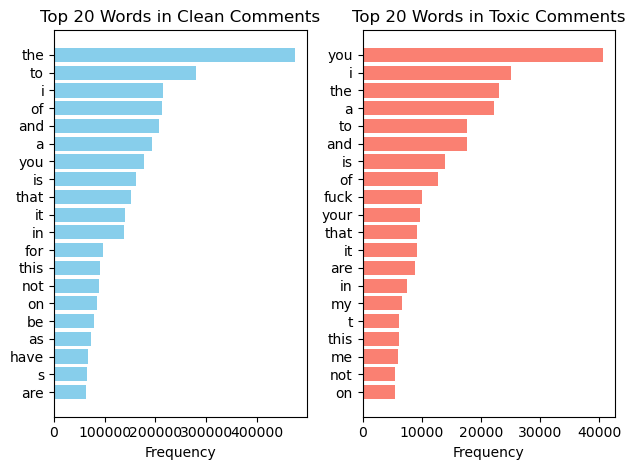

In [20]:
clean_words_list, clean_counts = zip(*clean_freq)
toxic_words_list, toxic_counts = zip(*toxic_freq)

# Clean words
plt.subplot(1, 2, 1)
plt.barh(clean_words_list[::-1], clean_counts[::-1], color='skyblue')
plt.title("Top 20 Words in Clean Comments")
plt.xlabel("Frequency")
plt.tight_layout()

# Toxic words
plt.subplot(1, 2, 2)
plt.barh(toxic_words_list[::-1], toxic_counts[::-1], color='salmon')
plt.title("Top 20 Words in Toxic Comments")
plt.xlabel("Frequency")
plt.tight_layout()

plt.show()

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sohan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
def clean_and_tokenize(text_series):
    # Lowercase and remove punctuation
    text = text_series.str.lower().str.replace(f"[{string.punctuation}]", " ", regex=True)

    # Split, flatten, drop NaN
    words = text.str.split().explode().dropna()

    # Only keep alphabetic words and remove stopwords
    words = words[words.str.isalpha()]

    # Apply stemming safely
    processed = []
    for word in words:
        word = word.strip()
        if word and word not in stop_words:
            try:
                processed.append(stemmer.stem(word))
            except RecursionError:
                continue  # skip the word if stemmer fails

    return processed

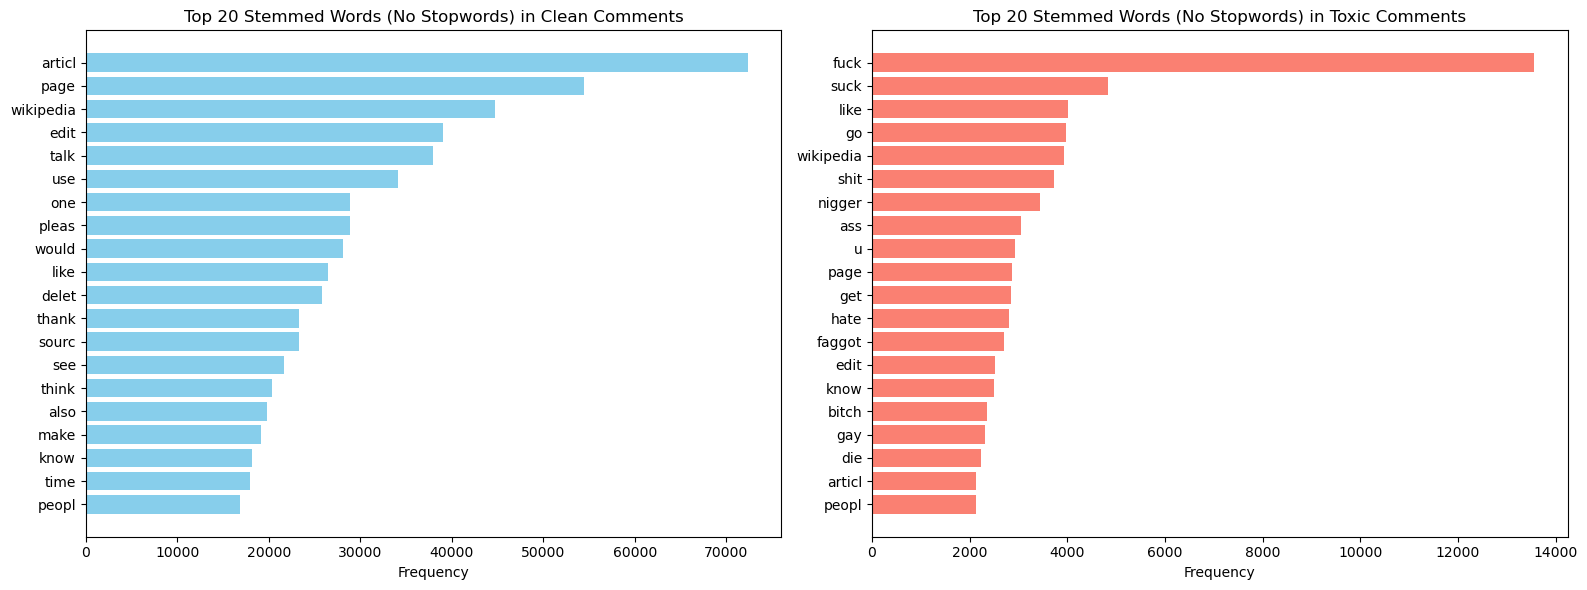

In [23]:
clean_words = clean_and_tokenize(clean_comments)
toxic_words = clean_and_tokenize(toxic_comments)

# Frequency counts
clean_freq = Counter(clean_words).most_common(20)
toxic_freq = Counter(toxic_words).most_common(20)

# Plotting
clean_words_list, clean_counts = zip(*clean_freq)
toxic_words_list, toxic_counts = zip(*toxic_freq)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.barh(clean_words_list[::-1], clean_counts[::-1], color='skyblue')
plt.title("Top 20 Stemmed Words (No Stopwords) in Clean Comments")
plt.xlabel("Frequency")

plt.subplot(1, 2, 2)
plt.barh(toxic_words_list[::-1], toxic_counts[::-1], color='salmon')
plt.title("Top 20 Stemmed Words (No Stopwords) in Toxic Comments")
plt.xlabel("Frequency")

plt.tight_layout()
plt.show()

## Data Preprocessing

In [24]:
# Data Preprocessings I found in kaggle kernel

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
RE_PATTERNS = {
    ' fuck':
        [
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*[ck]+[a-z@#\$%\^&\*]*',
            'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)',
            'feck ', ' fux ', 'f\*\*',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck\b', '\bf ck\b','\bfuk\b', 'wtf','fucck','f cking', 'fcking'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$'
                                                           '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'
        ],

    ' asshole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'ass hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h','beetch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' transgender':
        [
            'trans gender'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k','diick ', 'd+\s?[\*i1!-]+\s?[\*c-]+\s?[\*k-]+'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
             'c u n t', '\sc+[ -]?[@u*]+[ -]*[n*-]{1,3}\s?[t*-]'
        ],

    ' bullshit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homosexual':
        [
            'homo sexual','homosex'
        ],


    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots', 'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', 's[ -]?[h*][ -]*[i!*][ -]*t+', 'shite', '\$hit\b', 's h i t'
        ],

    ' shithole ':
        [
            'shythole','shit hole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' dumbass':
        [
            'dumb ass', 'dubass'
        ],

    ' asshead':
        [
            'butthead', 'ass head'
        ],

    ' sex ':
        [
            's3x',
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r', '\sn+[ -]?[i*]+[ -]*[g*-]{1,3}[ae*-]+\s?[r*]?'
        ],

    ' shut the fuck up':
        [
            'stfu'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', '\sp+[ -]?[u*]+[ -]*[$s*-]{1,3}\s?[yi]'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' motherfucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker', 'mother fucker'
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e', '\sw+[ -]?[h*]+[ -]*[o*-]{1,3}\s?[r*]+\s?[e*]?'
        ],
    ' kill ':
        [
            '\sk+[ -]?[!1i*]+[ -]*[1l*-]{1,3}'
        ],
    ' cocksucker ':
        [
            '\sc+[ -]?[!o0*]+[ -]?[c*-]{1,3}[ -]?[*k-]+[ -]?[s*]+[u*]+[ -]?[a-z]*'
        ]
}

In [27]:
import re

COMPILED_PATTERNS = [
    (re.compile(pat, flags=re.IGNORECASE), target)
    for target, patterns in RE_PATTERNS.items()
    for pat in patterns
]

In [28]:
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
"]+", flags=re.UNICODE)

In [29]:
def replace_abbrev(text):
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r'(\w+in)(\')(\s)', r'\1g\3', text)  # fix -in'
    return text

In [30]:
def replace_multi_punc(text):
    text = re.sub(r'([.])\1{3,}', ' mpm ', text)
    text = re.sub(r'([!])\1{3,}', ' mxm ', text)
    text = re.sub(r'([?])\1{3,}', ' mqm ', text)
    text = re.sub(r'([*])\1{3,}', '*', text)
    return text

In [31]:
def replace_url(text):
    text = re.sub(r'(www\.[^\s]+|https?://[^\s]+)', ' url ', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

In [32]:
from nltk import SnowballStemmer

def stem(text, stemmer=SnowballStemmer('english')):
    return ' '.join(stemmer.stem(t) for t in text.split())

In [33]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sohan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sohan\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sohan\AppData\Roaming\nltk_data...


True

In [34]:
from nltk import WordNetLemmatizer

def lemm(text, lemmatizer=WordNetLemmatizer()):
    from nltk.tokenize import wordpunct_tokenize
    tokens = wordpunct_tokenize(text)
    return ' '.join(lemmatizer.lemmatize(t) for t in tokens)

In [35]:
def clean(text, stem_on=False, lemm_on=True):
    text = str(text).lower().strip()

    text = replace_abbrev(text)
    text = re.sub(r"(u|U)ser:[a-zA-Z\d]{3,15}", 'stmsr', text)
    text = re.sub(r"([\d]{1,2}\s(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec),?\s?[\d]{4})", 'dttm', text, flags=re.IGNORECASE)
    text = re.sub(r'[\d]{2}:[\d]{2}', 'dttm', text)

    text = replace_url(text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'(([0-9]+\.){2,}[0-9]+)', 'stmip', text)

    text = replace_multi_punc(text)
    text = re.sub(r'([a-z])\1{2,}\b', r'\1\1', text)
    text = re.sub(r'([a-z])\1{3,}', r'\1\1\1', text)

    for pat, target in COMPILED_PATTERNS:
        text = pat.sub(target, text)

    text = emoji_pattern.sub('', text)
    text = re.sub(r"[^a-z.!?']", " ", text)
    text = re.sub(r'\s+', ' ', text)

    if stem_on:
        text = stem(text)
    elif lemm_on:
        text = lemm(text)

    return text

In [36]:
def preprocess_dataframe(df, text_column='comment_text', stem_on=False, lemm_on=True):
    df = df.copy()
    df['clean_text'] = df[text_column].apply(lambda x: clean(x, stem_on=stem_on, lemm_on=lemm_on))
    return df

In [37]:
train_df = preprocess_dataframe(train_df, text_column='comment_text')

In [38]:
# after all the preprocessing of data
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_count,text_length,clean_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112,d ' aww ! he match this background colour i am...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233,hey man i am really not trying to edit war . i...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622,more i ca not make any real suggestion on impr...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67,you sir are my hero . any chance you remember ...


## Training

### Bag of Words and ML algorithms

In [39]:
from sklearn.model_selection import train_test_split

# Train/test split
X_temp, X_test, y_temp, y_test = train_test_split(train_df['clean_text'], train_df[label_cols], test_size=0.2, random_state=42)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [40]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sohan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def preprocess_text(text):
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [42]:
X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [43]:
X_train.shape

(102124,)

In [44]:
X_train.iloc[0]

'. would verifi john wa pratt grad w ba b graphic art'

In [45]:
# bag-of-words
bow_vectorizer = CountVectorizer(max_features=10000, min_df=2, max_df=0.9)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)

In [46]:
X_train_bow.shape

(102124, 10000)

In [47]:
X_train_bow[0]

<1x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [48]:
# tf-idf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.9)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [49]:
X_train_tfidf.shape

(102124, 10000)

In [50]:
X_train_tfidf[0]

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

models = {
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)),
    "Decision Tree": OneVsRestClassifier(DecisionTreeClassifier(random_state=42)),
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
}

datasets = {
    "BoW": (X_train_bow, X_val_bow),
    "TF-IDF": (X_train_tfidf, X_val_tfidf)
}

for model_name, model in models.items():
    print(f"\n=== {model_name} ===")
    for vec_name, (X_tr, X_val) in datasets.items():
        print(f"\n-- Using {vec_name} --")
        model.fit(X_tr, y_train)
        preds = model.predict(X_val)
        print(classification_report(y_val, preds))


=== Logistic Regression ===

-- Using BoW --
              precision    recall  f1-score   support

           0       0.84      0.67      0.75      2503
           1       0.51      0.24      0.33       253
           2       0.85      0.69      0.76      1374
           3       0.27      0.21      0.24        70
           4       0.71      0.44      0.54      1310
           5       0.40      0.17      0.24       220

   micro avg       0.79      0.58      0.67      5730
   macro avg       0.60      0.40      0.48      5730
weighted avg       0.78      0.58      0.66      5730
 samples avg       0.06      0.05      0.05      5730


-- Using TF-IDF --
              precision    recall  f1-score   support

           0       0.91      0.63      0.75      2503
           1       0.53      0.22      0.31       253
           2       0.90      0.67      0.77      1374
           3       0.67      0.11      0.20        70
           4       0.81      0.52      0.63      1310
           5

### Embeddings + DL Model

In [60]:
embedding_file = "glove.6B.100d.txt"

In [61]:
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(42)

In [62]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
MAX_NUM_WORDS = 20000
MAX_SEQ_LENGTH = 300
EMBEDDING_DIM = 100

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

# Convert texts to sequences and pad
sequences = tokenizer.texts_to_sequences(train_df['clean_text'])
word_index = tokenizer.word_index
X_seq = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

In [63]:
import numpy as np

# Load GloVe
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [64]:
sample_text = train_df['clean_text'].iloc[0]
print("Original cleaned text:", sample_text)

#  Convert to sequence + pad
seq   = tokenizer.texts_to_sequences([sample_text])
padded = pad_sequences(seq, maxlen=MAX_SEQ_LENGTH)
print("\nPadded sequence (word indices):\n", padded)

# Lookup embeddings
sample_embedding = embedding_matrix[padded]
print("\nEmbedding tensor shape:", sample_embedding.shape)

# Show the last 5 time‑steps’ vectors
print("\nLast 5 embedded word vectors:")
for i, vec in enumerate(sample_embedding[0, -5:, :]):
    print(f" Step {i+1:02d} → {vec[:10]}…")

Original cleaned text: explanation why the edits made under my username hardcore metallica fan were reverted ? they were not vandalism just closure on some gas after i voted at new york doll fac . and please do not remove the template from the talk page since i am retired now . stmip

Padded sequence (word indices):
 [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0  

In [65]:
y_all = train_df[label_cols].values

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant

VOCAB_SIZE = embedding_matrix.shape[0]
NUM_CLASSES = y_all.shape[1]

model = Sequential([
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=MAX_SEQ_LENGTH,
        trainable=False
    ),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='sigmoid')
])

In [67]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [69]:
history = model.fit(X_seq, y_all, epochs=3, batch_size=128, validation_split=0.2)

Epoch 1/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 6523s 7s/step - accuracy: 0.7100 - loss: 0.1139 - val_accuracy: 0.9941 - val_loss: 0.0572
Epoch 2/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 6764s 7s/step - accuracy: 0.9347 - loss: 0.0556 - val_accuracy: 0.9939 - val_loss: 0.0541
Epoch 3/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 7264s 7s/step - accuracy: 0.9391 - loss: 0.0508 - val_accuracy: 0.9938 - val_loss: 0.0504


In [70]:
model.layers[0].trainable = True

# Recompile with a lower learning rate
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

In [72]:
history = model.fit(X_seq, y_all, epochs=3, batch_size=128, validation_split=0.2)

Epoch 1/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 6534s 7s/step - accuracy: 0.9312 - loss: 0.0446 - val_accuracy: 0.9940 - val_loss: 0.0474
Epoch 2/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 6834s 7s/step - accuracy: 0.9237 - loss: 0.0432 - val_accuracy: 0.9940 - val_loss: 0.0469
Epoch 3/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 6958s 7s/step - accuracy: 0.9011 - loss: 0.0422 - val_accuracy: 0.9940 - val_loss: 0.0466


In [73]:
y_pred_prob = model.predict(X_seq)
y_pred = (y_pred_prob >= 0.5).astype(int)

print(classification_report(y_all, y_pred, target_names=label_cols))

4987/4987 ━━━━━━━━━━━━━━━━━━━━ 1872s 375ms/step
               precision    recall  f1-score   support

        toxic       0.87      0.79      0.83     15294
 severe_toxic       0.59      0.24      0.34      1595
      obscene       0.86      0.79      0.83      8449
       threat       0.00      0.00      0.00       478
       insult       0.77      0.74      0.76      7877
identity_hate       0.75      0.00      0.01      1405

    micro avg       0.84      0.71      0.77     35098
    macro avg       0.64      0.43      0.46     35098
 weighted avg       0.82      0.71      0.74     35098
  samples avg       0.07      0.07      0.07     35098



### Attention Mechanism

In [74]:
from tensorflow.keras.layers import Layer

class DotProductAttention(Layer):
    def __init__(self):
        super(DotProductAttention, self).__init__()

    def call(self, inputs):
        query = inputs  # Q = inputs
        key = inputs     # K = inputs
        value = inputs   # V = inputs

        scores = tf.matmul(query, key, transpose_b=True)
        scores = scores / tf.math.sqrt(tf.cast(tf.shape(inputs)[-1], tf.float32))
        weights = tf.nn.softmax(scores, axis=-1)
        output = tf.matmul(weights, value)
        return output

In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling1D

# Inputs
input_seq = Input(shape=(MAX_SEQ_LENGTH,))

# Embedding layer
embedding_layer = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=MAX_SEQ_LENGTH,
    trainable=False
)(input_seq)

# BiLSTM + Dropout
x = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.5)(x)

# 🔥 Attention Layer
attention_output = DotProductAttention()(x)

# Global average pooling
x = GlobalAveragePooling1D()(attention_output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Output
output = Dense(NUM_CLASSES, activation='sigmoid')(x)

# Model
model = Model(inputs=input_seq, outputs=output)

In [76]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy', optimizer=Adam(1e-2), metrics=['accuracy'])

history = model.fit(X_seq, y_all, epochs=3, batch_size=128, validation_split=0.2)

Epoch 1/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 5700s 6s/step - accuracy: 0.9170 - loss: 0.1029 - val_accuracy: 0.9941 - val_loss: 0.0580
Epoch 2/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 5584s 6s/step - accuracy: 0.9929 - loss: 0.0543 - val_accuracy: 0.9941 - val_loss: 0.0549
Epoch 3/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 5688s 6s/step - accuracy: 0.9890 - loss: 0.0509 - val_accuracy: 0.9941 - val_loss: 0.0571


In [77]:
model.layers[1].trainable = True

model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])

# Fine-tuning with trainable embeddings
history_finetune = model.fit(X_seq, y_all, epochs=3, batch_size=128, validation_split=0.2)

Epoch 1/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 10466s 10s/step - accuracy: 0.9946 - loss: 0.0472 - val_accuracy: 0.9941 - val_loss: 0.0521
Epoch 2/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 5545s 6s/step - accuracy: 0.9946 - loss: 0.0454 - val_accuracy: 0.9941 - val_loss: 0.0516
Epoch 3/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 5809s 6s/step - accuracy: 0.9945 - loss: 0.0440 - val_accuracy: 0.9941 - val_loss: 0.0512


In [78]:
y_pred_prob = model.predict(X_seq)
y_pred = (y_pred_prob >= 0.5).astype(int)

print(classification_report(y_all, y_pred, target_names=label_cols))

4987/4987 ━━━━━━━━━━━━━━━━━━━━ 3327s 667ms/step
               precision    recall  f1-score   support

        toxic       0.81      0.84      0.82     15294
 severe_toxic       0.83      0.05      0.09      1595
      obscene       0.83      0.81      0.82      8449
       threat       0.00      0.00      0.00       478
       insult       0.74      0.72      0.73      7877
identity_hate       0.00      0.00      0.00      1405

    micro avg       0.80      0.72      0.76     35098
    macro avg       0.53      0.40      0.41     35098
 weighted avg       0.76      0.72      0.72     35098
  samples avg       0.07      0.07      0.07     35098

